In [207]:
import numpy as np

In [208]:
class Loss:
    def __init__(self, lossType = "MSE"):
        self.lossType = lossType 
    
    def backwardPass(self, X, Y):
        if(self.lossType == "MSE"):
            return self.backwardPassMSE(X, Y)
        elif(self.lossType == "CE"):
            return self.backwardPassCE(X,Y)
        return
    
    def forwardPass(self, X, Y):
        if(self.lossType == "MSE"):
            return self.forwardPassMSE(X, Y)
        elif(self.lossType == "CE"):
            return self.forwardPassCE(X,Y)
        return
   
    def forwardPassMSE(self, X, Y):
        return ((X-Y).T)@(X-Y)*0.5
    
    def forwardPassCE(self, X, Y):
        return -np.sum(Y*np.log(X))
   
    def backwardPassMSE(self, P, Y):
        return P-Y
    
    def backwardPassCE(self,P,Y):
        return Y/P
    


In [209]:
class Activation:
    def __init__(self, act = "linear"):
        self.act = act 
    
    def backwardPass(self, X, dl_dn):
        if(self.act == "linear"):
            return self.backwardPassLinear(X, dl_dn)
        elif(self.act == "sigmoid"):
            return self.backwardPassSigmoid(X, dl_dn)
        elif(self.act == "softmax"):
            return self.backwardPassSoftmax(X, dl_dn)
        return
    
    def forwardPass(self, X):
        if(self.act == "linear"):
            return self.forwardPassLinear(X)
        elif(self.act == "sigmoid"):
            return self.forwardPassSigmoid(X)
        elif(self.act == "softmax"):
            return self.forwardPassSoftmax(X)
        return
   
    def forwardPassLinear(self, X):
        return X
    
    def forwardPassSigmoid(self, X):
        return 1/(1 + np.exp(-X))
    
    def forwardPassSoftmax(self, X):
        retsum = np.sum(np.exp(X-np.max(X)), axis=1)
        retsum = retsum.reshape(X.shape[0],1)
        N = np.exp(X-np.max(X))/retsum

    def backwardPassLinear(self, X, dl_dn):
        return 1
    
    def backwardPassSigmoid(self, X, dl_dn):
        return self.forwardPassSigmoid(X) * (1 - self.forwardPassSigmoid(X))

    def backwardPassSoftmax(self, X, dl_dn):
        N = self.forwardPassSoftmax(X)
        dl_dx = N*(dl_dn - np.sum(dl_dn*N, axis=1).reshape(X.shape[0], 1))
        return dl_dx
    



In [210]:
class Layer:
    def __init__(self, numNeurons = 1, numNeuronsPrev = 1, act = "linear", alpha = 1e-7):
        # Neurons in the current layer
        self.numNeurons = numNeurons
        # Neurons in the previous layer
        self.numNeuronsPrev = numNeuronsPrev
        # Weights for linear sum
        self.W = np.random.rand(numNeurons, numNeuronsPrev)
        # Bias of size Nx1
        self.B = np.random.rand(numNeurons, 1)
        # Activation function 
        self.activation = Activation(act)
        self.alpha = alpha
        self.input = None
        self.output = None

    def update(self, dl_dw, dl_db):
        self.W -= self.alpha*(dl_dw)
        self.B -= self.alpha*(dl_db)
    def forwardPasslinear(self, X, train=False):
        if(train):
            self.input = X
        return (self.W)@X + (self.B)
    
    def forwardPass(self, X):
        arg = self.forwardPasslinear(X, True)
        return self.activation.forwardPass(arg)
    
    def backwardPasslinear(self, dl_ds):
        # dl_dx = np.zeros((dl_dw.shape[1], 1))
        dl_dx = self.W.T@dl_ds
        dl_dw = (dl_ds@(self.input).T)
        return (dl_dx, dl_dw)
    
    def backwardPass(self, dl_dh):
        # dl_ds where S = W@X + B
        dl_ds = dl_dh*self.activation.backwardPass(self.forwardPasslinear(self.input, True), dl_dh)  
        dl_dx, dl_dw = self.backwardPasslinear(dl_ds)

        self.update(dl_dw, dl_ds)
        return dl_dx

        # fw= self.forwardPasslinear(self.input)
        # dl_dx = dl_dh * (self.activation.backwardPass(fw))
        # return self.backwardPasslinear(dl_dx)

In [211]:
class NeuralNetwork:
    def __init__(self, listLayers = [], str = "MSE", inp = np.zeros((10,5)), pred = np.ones((10,1)), epochs = 1e4):
        self.listLayers = listLayers
        self.lossObj = Loss(str)
        self.target = pred
        # Input data to the neural network
        self.input = inp
        self.epochs = epochs
    
    def forwardPassNN(self, i, Y):
        R = self.listLayers[i].forwardPass(Y)
        return R

    def train(self):
        for epoch in range(int(self.epochs)):
            loss = 0
            for d in range(len(self.input)):
                # l = []
                Y = self.input[d].reshape(self.input.shape[1], 1)
                # l.append(Y)
                for i in range(len(self.listLayers)):
                    Y = self.forwardPassNN(i, Y)
                    # l.append(Y)
                
                # targ = self.target[d].reshape(self.target.shape[1],1)
                myLoss = self.lossObj.forwardPass(Y, self.target[d])
                loss += myLoss
                dl_dh = self.lossObj.backwardPass(l[-1], self.target[d])
                for i in range(len(self.listLayers) -1, -1, -1):
                    dl_dh = self.listLayers[i].backwardPass(dl_dh)
            print(loss/len(self.input))
    
    def test(self, dataPts, targets):
        ret = np.zeros((dataPts.shape[0], 1))
        for ind in range(len(dataPts)):
            Y = dataPts[ind].reshape(dataPts.shape[1], 1)
            for i in range(len(self.listLayers)):
                Y = self.forwardPassNN(i, Y)
            ret[ind] = Y.item()
        return ret   


In [212]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
X = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
Y = raw_df.values[1::2, 2]
Y = Y.reshape((Y.shape[0],1))

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [213]:
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(404, 13)
(102, 13)
(404, 1)
(102, 1)


In [214]:
layers = []
layers.append(Layer(2, X_train.shape[1], "sigmoid"))
layers.append(Layer(2, 2, "sigmoid"))
layers.append(Layer(1, 2, "linear"))

model = NeuralNetwork(layers, "MSE", X_train, Y_train)
model.train()


[[271.96040543]]
[[271.91919497]]
[[271.87798564]]
[[271.83677744]]
[[271.79557036]]
[[271.75436441]]
[[271.71315958]]
[[271.67195588]]
[[271.6307533]]
[[271.58955184]]
[[271.54835151]]
[[271.5071523]]
[[271.46595422]]
[[271.42475725]]
[[271.38356142]]
[[271.3423667]]
[[271.3011731]]
[[271.25998063]]
[[271.21878927]]
[[271.17759904]]
[[271.13640993]]
[[271.09522194]]
[[271.05403507]]
[[271.01284932]]
[[270.97166469]]
[[270.93048118]]
[[270.88929879]]
[[270.84811752]]
[[270.80693736]]
[[270.76575833]]
[[270.72458041]]
[[270.68340362]]
[[270.64222794]]
[[270.60105338]]
[[270.55987994]]
[[270.51870762]]
[[270.47753641]]
[[270.43636632]]
[[270.39519735]]
[[270.3540295]]
[[270.31286277]]
[[270.27169715]]
[[270.23053265]]
[[270.18936927]]
[[270.148207]]
[[270.10704586]]
[[270.06588583]]
[[270.02472691]]
[[269.98356912]]
[[269.94241244]]
[[269.90125688]]
[[269.86010244]]
[[269.81894911]]
[[269.7777969]]
[[269.73664581]]
[[269.69549584]]
[[269.65434698]]
[[269.61319924]]
[[269.57205262]]
[[269

10.290899932610097
[[16.12464631]
 [16.12464631]
 [16.12464631]
 [16.12464631]
 [16.12464631]
 [16.12464631]
 [16.12464631]
 [16.12464631]
 [16.12464631]
 [16.12464631]
 [16.12464631]
 [16.12464631]
 [16.12464631]
 [16.12464631]
 [16.12464631]
 [16.12464631]
 [16.12464631]
 [16.12464631]
 [16.12464631]
 [16.12464631]
 [16.12464631]
 [16.12464631]
 [16.12464631]
 [16.12464631]
 [16.12464631]
 [16.12464631]
 [16.12464631]
 [16.12464631]
 [16.12464631]
 [16.12464631]
 [16.12464631]
 [16.12464631]
 [16.12464631]
 [16.12464631]
 [16.12464631]
 [16.12464631]
 [16.12464631]
 [16.12464631]
 [16.12464631]
 [16.12464631]
 [16.12464631]
 [16.12464631]
 [16.12464631]
 [16.12464631]
 [16.12464631]
 [16.12464631]
 [16.12464631]
 [16.12464631]
 [16.12464631]
 [16.12464631]
 [16.12464631]
 [16.12464631]
 [16.12464631]
 [16.12464631]
 [16.12464631]
 [16.12464631]
 [16.12464631]
 [16.12464631]
 [16.12464631]
 [16.12464631]
 [16.12464631]
 [16.12464631]
 [16.12464631]
 [16.12464631]
 [16.12464631]
 [16.1

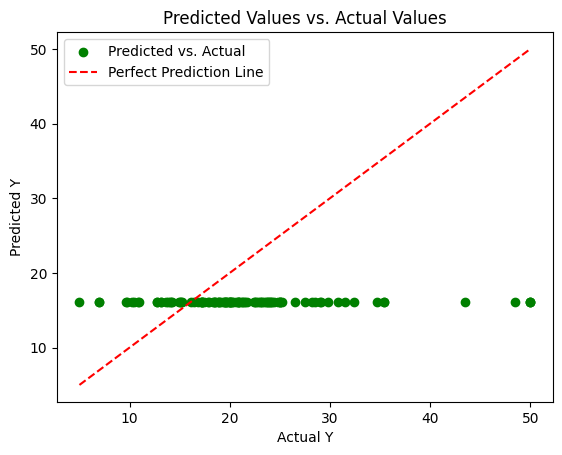

In [215]:
Y_pred = model.test(X_test, Y_test)

print(((np.sum((Y_pred-Y_test)**2)))*0.5*(1/506))
# Plotting the curve for predicted values versus actual values
# plt.scatter(Y_test, Y_pred, color='blue', label='Predicted vs. Actual')
# plt.plot([min(Y), max(Y)], [min(Y), max(Y)], linestyle='--', color='red', label='Perfect Prediction Line')
# plt.title('Predicted Values vs. Actual Values')
# plt.xlabel('Actual Y')
# plt.ylabel('Predicted Y')
# plt.legend()
# plt.show()
print( Y_pred)
plt.scatter(Y_test, Y_pred, color='green', label='Predicted vs. Actual')
plt.plot([min(Y_test), max(Y_test)], [min(Y_test), max(Y_test)], linestyle='--', color='red', label='Perfect Prediction Line')
plt.title('Predicted Values vs. Actual Values')
plt.xlabel('Actual Y')
plt.ylabel('Predicted Y')
plt.legend()
plt.show()


In [217]:
print(layers[0].W)
print(layers[1].W)
print(layers[2].W)

[[0.85557781 0.72813975 0.14709447 0.863597   0.49586246 0.53828381
  0.70328604 0.82043147 0.93983161 0.13344189 0.06752766 0.83275288
  0.19734447]
 [0.54822505 0.48071431 0.96771332 0.60503429 0.9318649  0.96172426
  0.2934344  0.65028399 0.07083779 0.75215076 0.87852886 0.41944359
  0.04487965]]
[[1.06052289 0.99280604]
 [1.23420426 1.34215129]]
[[5.561526   5.18362599]]
